**Load data and packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import torch
from torch import nn
import torch.utils.data as data_utils
from torchvision import datasets
import torchvision.transforms as transforms

import NN_utils_lies

torch.manual_seed(1234)
np.random.seed(1234)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.cuda.is_available()

True

In [4]:
train_dev_set = datasets.FashionMNIST('./data', train=True, download=True)
train_dev_images = train_dev_set.data
train_dev_labels = train_dev_set.targets

test_set = datasets.FashionMNIST('./data', train=False, download=True)
test_images = test_set.data
test_labels = test_set.targets

In [5]:
train_images, dev_images, train_labels, dev_labels = train_test_split(train_dev_images, train_dev_labels, test_size=10000,
                                                    random_state=1234, stratify=train_dev_labels)

**Visualize data**

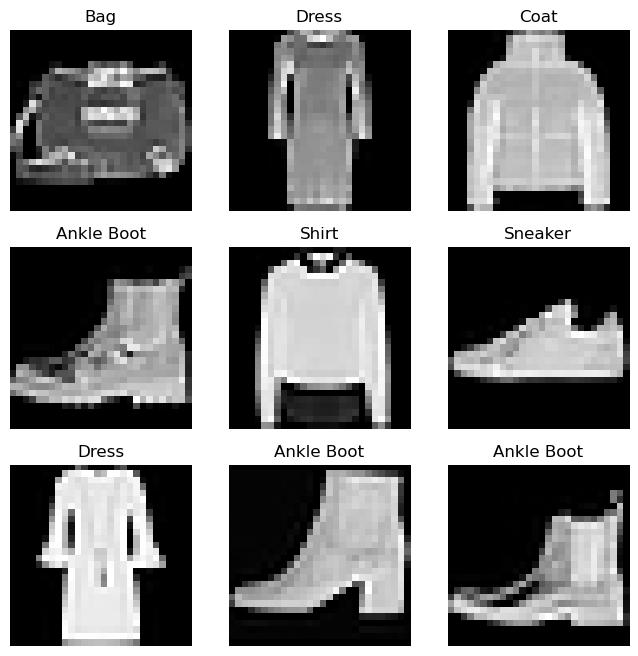

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_images), size=(1,)).item()
    img = train_images[sample_idx]
    label = train_labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(train_images[sample_idx], cmap='gray')
plt.show()


In [7]:
preprocess_images = transforms.Compose([transforms.ToPILImage(),
                                        lambda x: x.convert("RGB"),
                                        transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_images = torch.stack([preprocess_images(img) for img in train_images], dim=0)
dev_images = torch.stack([preprocess_images(img) for img in dev_images], dim=0)
test_images = torch.stack([preprocess_images(img) for img in test_images], dim=0)

In [8]:
train_images.shape, train_labels.shape

(torch.Size([50000, 3, 28, 28]), torch.Size([50000]))

In [9]:
torch.unique(train_labels, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [10]:
dev_images.shape, dev_labels.shape

(torch.Size([10000, 3, 28, 28]), torch.Size([10000]))

In [11]:
torch.unique(dev_labels, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [12]:
test_images.shape, test_labels.shape

(torch.Size([10000, 3, 28, 28]), torch.Size([10000]))

In [13]:
torch.unique(test_labels, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

**Prepare data for training**

In [14]:
def dataLoader(x, y, shuffle):
  dataset = data_utils.TensorDataset(x,y)
  dataloader = data_utils.DataLoader(dataset, batch_size=64, shuffle=shuffle)
  return dataloader

In [15]:
train_loader = dataLoader(train_images, train_labels, shuffle=True)
dev_loader = dataLoader(dev_images, dev_labels, shuffle=False)
test_loader = dataLoader(test_images, test_labels, shuffle=False)

label is:  Pullover


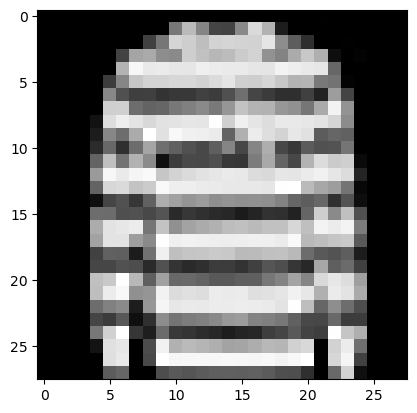

In [16]:
train_features, train_labels = next(iter(train_loader))
plt.imshow(train_features[0][0], cmap='gray')
print('label is: ', labels_map[train_labels[0].item()])

**Build model**

In [17]:
class printModule(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

class fashionCNN(nn.Module):
  def __init__(self):
    super(fashionCNN, self).__init__()
    self.cnn =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool2d(2),

                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                              nn.ReLU())


    self.linear =  nn.Sequential(nn.Linear(128 * 5 * 5, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 10))


  def forward(self, x):
    x = self.cnn(x)
    x = torch.flatten(x, start_dim=1, end_dim=-1)
    x = self.linear(x)
    return x


In [18]:
fashionCNN = fashionCNN().to(device)

**Train model**

In [19]:
history = NN_utils_lies.train(fashionCNN, nn.CrossEntropyLoss(), torch.optim.AdamW(fashionCNN.parameters(), weight_decay=1e-5, lr=1e-3),
          train_loader, dev_loader, num_epochs=50, 
          record_weights=None, early_stopping=NN_utils_lies.EarlyStopping(patience=10))

epoch 1 train loss: 0.6222  validation loss: 0.4394  validation accuracy: 0.8411 
epoch 2 train loss: 0.3523  validation loss: 0.3176  validation accuracy: 0.8855 
epoch 3 train loss: 0.2944  validation loss: 0.3036  validation accuracy: 0.8875 
epoch 4 train loss: 0.2643  validation loss: 0.2826  validation accuracy: 0.8971 
epoch 5 train loss: 0.2356  validation loss: 0.2710  validation accuracy: 0.9025 
epoch 6 train loss: 0.2168  validation loss: 0.2710  validation accuracy: 0.9049 
epoch 7 train loss: 0.1934  validation loss: 0.2447  validation accuracy: 0.9140 
epoch 8 train loss: 0.1754  validation loss: 0.2434  validation accuracy: 0.9175 
epoch 9 train loss: 0.1531  validation loss: 0.2949  validation accuracy: 0.9105 
epoch 10 train loss: 0.1343  validation loss: 0.2825  validation accuracy: 0.9172 
epoch 11 train loss: 0.1274  validation loss: 0.3188  validation accuracy: 0.9105 
epoch 12 train loss: 0.1086  validation loss: 0.2891  validation accuracy: 0.9152 
epoch 13 trai

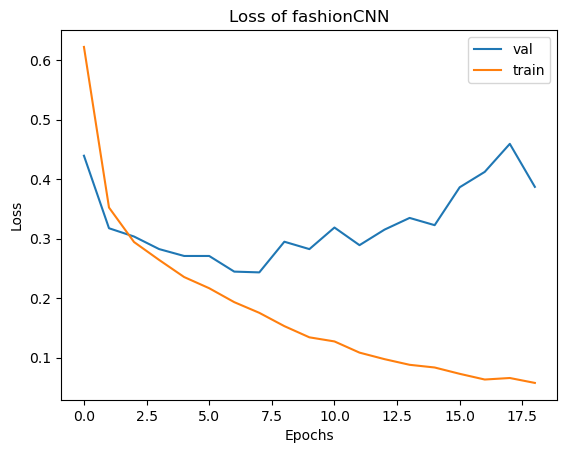

In [20]:
plt.plot(history['validation_loss'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss of fashionCNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

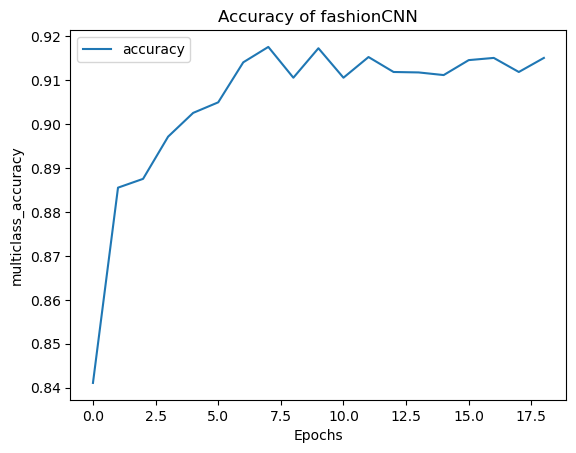

In [21]:
plt.plot(history['validation_accuracy'],  label='accuracy')
plt.title('Accuracy of fashionCNN')
plt.xlabel('Epochs')
plt.ylabel('multiclass_accuracy')
plt.legend()
plt.show()

**Test model**

In [22]:
pred = NN_utils_lies.test(fashionCNN, test_loader)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.89      0.84      0.86      1000
           3       0.93      0.90      0.91      1000
           4       0.83      0.88      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.72      0.73      0.73      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



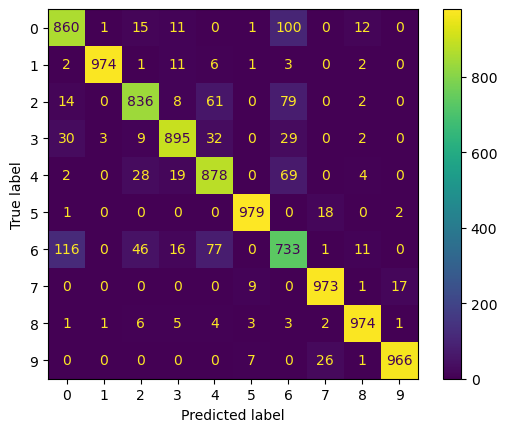

In [23]:
ConfusionMatrixDisplay.from_predictions(test_labels, pred)

**Train model with dropout**

In [24]:
class fashionCNN_dropout(nn.Module):
  def __init__(self):
    super(fashionCNN_dropout, self).__init__()
    self.cnn =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.ReLU(),
                              nn.MaxPool2d(2),
                              nn.Dropout(0.3),

                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.Dropout(0.3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                              nn.Dropout(0.3),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                              nn.Dropout(0.3),
                              nn.ReLU())


    self.linear =  nn.Sequential(nn.Linear(128 * 5 * 5, 256),
                                 nn.Dropout(0.5),
                                 nn.ReLU(),
                                 nn.Linear(256, 256),
                                 nn.Dropout(0.5),
                                 nn.ReLU(),
                                 nn.Linear(256, 10))


  def forward(self, x):
    x = self.cnn(x)
    x = torch.flatten(x, start_dim=1, end_dim=-1)
    x = self.linear(x)
    return x

In [25]:
fashionCNN_dropout = fashionCNN_dropout().to(device)

In [26]:
history_dropout = NN_utils_lies.train(fashionCNN_dropout, nn.CrossEntropyLoss(), torch.optim.AdamW(fashionCNN_dropout.parameters(), weight_decay=1e-5, lr=1e-3),
          train_loader, dev_loader, num_epochs=50, 
          record_weights=None, early_stopping=NN_utils_lies.EarlyStopping(patience=10))

epoch 1 train loss: 0.8011  validation loss: 0.5394  validation accuracy: 0.7811 
epoch 2 train loss: 0.5054  validation loss: 0.3760  validation accuracy: 0.8688 
epoch 3 train loss: 0.4116  validation loss: 0.3322  validation accuracy: 0.8845 
epoch 4 train loss: 0.3766  validation loss: 0.3018  validation accuracy: 0.8913 
epoch 5 train loss: 0.3448  validation loss: 0.2786  validation accuracy: 0.8969 
epoch 6 train loss: 0.3297  validation loss: 0.2660  validation accuracy: 0.9038 
epoch 7 train loss: 0.3140  validation loss: 0.2618  validation accuracy: 0.9067 
epoch 8 train loss: 0.3019  validation loss: 0.2493  validation accuracy: 0.9082 
epoch 9 train loss: 0.2990  validation loss: 0.2651  validation accuracy: 0.9030 
epoch 10 train loss: 0.2949  validation loss: 0.2510  validation accuracy: 0.9114 
epoch 11 train loss: 0.2850  validation loss: 0.2406  validation accuracy: 0.9120 
epoch 12 train loss: 0.2815  validation loss: 0.2522  validation accuracy: 0.9074 
epoch 13 trai

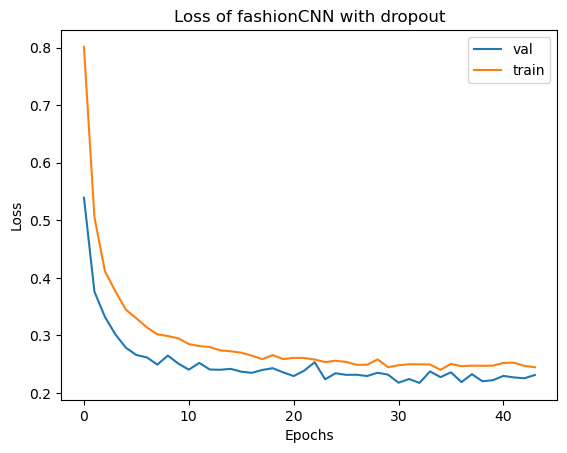

In [27]:
plt.plot(history_dropout['validation_loss'],  label='val')
plt.plot(history_dropout['train_loss'], label='train')
plt.title('Loss of fashionCNN with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

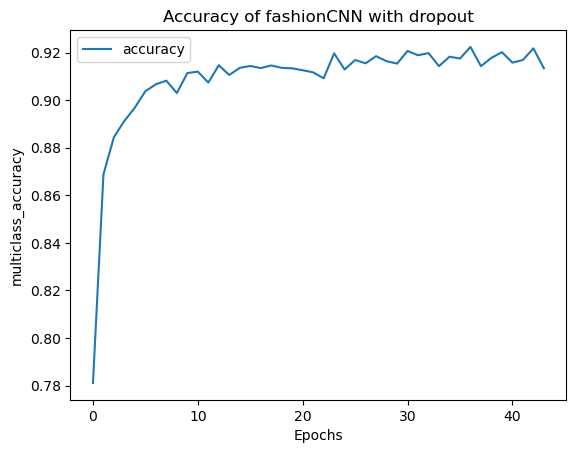

In [28]:
plt.plot(history_dropout['validation_accuracy'],  label='accuracy')
plt.title('Accuracy of fashionCNN with dropout')
plt.xlabel('Epochs')
plt.ylabel('multiclass_accuracy')
plt.legend()
plt.show()

**Test model with dropout**

In [29]:
pred = NN_utils_lies.test(fashionCNN_dropout, test_loader)
pred = np.argmax(pred, axis=1)

print(classification_report(y_pred=pred, y_true=test_labels))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1000
           1       1.00      0.97      0.98      1000
           2       0.86      0.89      0.87      1000
           3       0.87      0.94      0.90      1000
           4       0.87      0.85      0.86      1000
           5       0.98      0.97      0.98      1000
           6       0.77      0.70      0.73      1000
           7       0.92      0.99      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



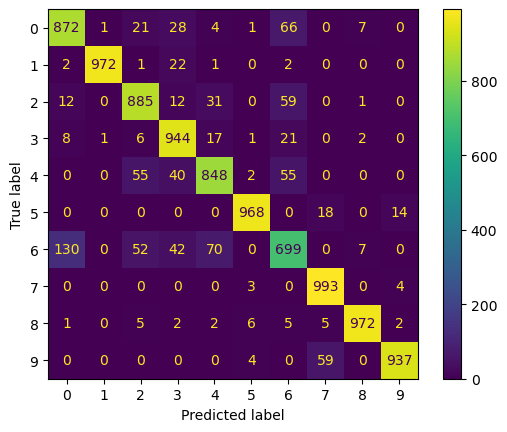

In [30]:
ConfusionMatrixDisplay.from_predictions(test_labels, pred)